# Bayesian Parameter Identification
## Setup Model and FEM (according to E2)

In [1]:
# For better printing within jupyter cells (otherwise only the last variable is printed)
import IPython; IPython.core.interactiveshell.InteractiveShell.ast_node_interactivity = "all"

# Standard python libraries
import os

# General computing libraries
import math
import numpy
import scipy.optimize

# Meshing libraries
import gmsh
import meshio

# Finite element libraries
import dolfin as df
df.parameters["allow_extrapolation"] = True

# Plotting libraries
import matplotlib.pyplot as plt

# VTK and visualization
import itkwidgets
import vtk

# Tracking libraries
import dolfin_warp as dwarp

# MEC581 python library
import LIB581

In [2]:
def create_mesh(
        X0,                   # first component of the center of the tube, in mm
        Y0,                   # second component of the center of the tube, in mm
        Ri,                   # internal radius of the tube, in mm
        Re,                   # external radius of the tube, in mm
        l,                    # characteristic size of the mesh cells, in mm
        mesh_folder="Project",     # folder the mesh file
        mesh_basename="mesh", # basename of the mesh file
        verbose=False):       # print or not the GMSH output

    ## Initialization of GMSH
    gmsh.initialize()
    if not (verbose): gmsh.option.setNumber("General.Terminal",0)
    gmsh.clear()

    ## Geometry
    factory = gmsh.model.geo

    # Points
    p0 = factory.addPoint(X0, Y0, 0, l) ### YOUR CODE HERE ###
    # 4 points on the inner loop
    p1 = factory.addPoint(X0+Ri, Y0, 0, l)
    p2 = factory.addPoint(X0, Y0+Ri, 0, l)
    p3 = factory.addPoint(X0-Ri, Y0, 0, l)
    p4 = factory.addPoint(X0, Y0-Ri, 0, l)
    # 4 points on the outer loop
    p5 = factory.addPoint(X0+Re, Y0, 0, l)
    p6 = factory.addPoint(X0, Y0+Re, 0, l)
    p7 = factory.addPoint(X0-Re, Y0, 0, l)
    p8 = factory.addPoint(X0, Y0-Re, 0, l)

    # Curves
    # 4 curves for the inner loop
    l11 = factory.addCircleArc(p1, p0, p2) ### YOUR CODE HERE ###
    l12 = factory.addCircleArc(p2, p0, p3)
    l13 = factory.addCircleArc(p3, p0, p4)
    l14 = factory.addCircleArc(p4, p0, p1)
    # 4 curves for the outer loop
    l21 = factory.addCircleArc(p5, p0, p6)
    l22 = factory.addCircleArc(p6, p0, p7)
    l23 = factory.addCircleArc(p7, p0, p8)
    l24 = factory.addCircleArc(p8, p0, p5)
    

    # Curve loop
    cl = factory.addCurveLoop([l11, l12, l13, l14, l21, l22, l23, l24])### YOUR CODE HERE ###

    # Surface
    s = factory.addPlaneSurface([cl]) ### YOUR CODE HERE ###

    # Synchronization, cf., e.g., https://gitlab.onelab.info/gmsh/gmsh/-/blob/master/tutorial/python/t1.py
    factory.synchronize()

    # In order to only save nodes and elements of the final surface
    # (i.e., not the construction points like the circle center,
    # nor the line elements of the line entities—remember that 
    # unstructured meshers will first mesh the curves, then the
    # surfaces and the volumes, cf. MEC552 L5.2), we declare it as a
    # "physical" surface.
    ps = gmsh.model.addPhysicalGroup(dim=2, tags=[s])

    ## Mesh
    mesh_gmsh = gmsh.model.mesh

    # Mesh generation
    mesh_gmsh.generate(dim=2)

    # In order to visualize the mesh and perform finite element computation using
    # FEniCS, we need to convert the mesh from the GMSH format to the VTK & FEniCS
    # formats. Since there is no direct converter between these formats, we do
    # that here by writing the mesh to the disc in VTK format using GMSH, which
    # we can then read in various formats later on.
    if not os.path.exists(mesh_folder): os.mkdir(mesh_folder)
    gmsh.write(mesh_folder+"/"+mesh_basename+".vtk")

    # Finalization of GMSH
    gmsh.finalize()

    # To convert the mesh from vtk to dolfin format,
    # we use [meshio](https://github.com/nschloe/meshio).
    mesh_meshio = meshio.read(mesh_folder+"/"+mesh_basename+".vtk")

    # For 2D meshes, we need to remove the third component of points,
    # otherwise FEniCS believes it is 3D…
    mesh_meshio.points = mesh_meshio.points[:, :2]

    # We write the mesh in XDMF format.
    meshio.write(mesh_folder+"/"+mesh_basename+".xdmf", mesh_meshio)

    # Finaly we can read the mesh in FEniCS format.
    mesh = df.Mesh()
    df.XDMFFile(mesh_folder+"/"+mesh_basename+".xdmf").read(mesh)

    return mesh

# Now we test the function.
mesh = create_mesh(X0=0.5, Y0=0.5, Ri=0.2, Re=0.3, l=0.1/5, verbose=1)

# We check some mesh informations.
print ("geometric_dimension:", mesh.geometric_dimension())
print ("num_vertices:", mesh.num_vertices())
print ("num_cells:", mesh.num_cells())

# We can define "measures", which allow to integrate expressions over (part of) the mesh.
dV = df.Measure("dx", domain=mesh) # "dx" means over the domain itself
mesh_V0 = df.assemble(df.Constant(1.) * dV)
print ("mesh_V0", mesh_V0)

# We visualize the mesh, by writing it to disk in VTK format, reading it,
# and using [itkwidgets](https://github.com/InsightSoftwareConsortium/itkwidgets).
LIB581.write_VTU_file("Project/mesh", mesh)
mesh_vtk = LIB581.read_VTU_file("Project/mesh")
itkwidgets.view(geometries=mesh_vtk)

Info    : Clearing all models and views...
Info    : Done clearing all models and views
Info    : Starting subloop 1 in curve loop 1 (are you sure about this?)
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Circle)
Info    : [ 20%] Meshing curve 2 (Circle)
Info    : [ 30%] Meshing curve 3 (Circle)
Info    : [ 40%] Meshing curve 4 (Circle)
Info    : [ 50%] Meshing curve 5 (Circle)
Info    : [ 70%] Meshing curve 6 (Circle)
Info    : [ 80%] Meshing curve 7 (Circle)
Info    : [ 90%] Meshing curve 8 (Circle)
Info    : Done meshing 1D (Wall 0.00130355s, CPU 0.00146s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0162799s, CPU 0.016622s)
Info    : 575 nodes 1157 elements
Info    : Writing 'Project/mesh.vtk'...
Info    : Done writing 'Project/mesh.vtk'
geometric_dimension: 2
num_vertices: 574
num_cells: 988
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this 

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

In [3]:
def create_boundaries(
        X0, Y0, Ri, Re,
        mesh):

    # We create a "MeshFunction",
    # which will allow us to assign an id to each edge of the mesh.

    boundaries_mf = df.MeshFunction(
        value_type="size_t", # size_t is like unisgned int, but more robust with respect to architecture and os
        mesh=mesh,
        dim=1) # 0 for nodes, 1 for edges, 2 for faces, etc.

    # We initialize it to zero.

    boundaries_mf.set_all(0)

    # Now we define geometrical subdomains.

    Si_sd = df.AutoSubDomain(
        lambda x, on_boundary:
            on_boundary and\
            df.near((x[0]-X0)**2+(x[1]-Y0)**2, Ri**2, eps=1e-3))### YOUR CODE HERE ###

    Se_sd = df.AutoSubDomain(
        lambda x, on_boundary:
            on_boundary and\
            df.near((x[0]-X0)**2+(x[1]-Y0)**2, Re**2, eps=1e-3))### YOUR CODE HERE ###

    # And we use the subdomains to mark the different parts of the mesh.

    Si_id = 1; Si_sd.mark(boundaries_mf, Si_id)
    Se_id = 2; Se_sd.mark(boundaries_mf, Se_id)

    return boundaries_mf

# Now we test the function.
X0 = 0.5; Y0 = 0.5; Ri = 0.2; Re = 0.3; l=0.1/3
mesh = create_mesh(X0=X0, Y0=Y0, Ri=Ri, Re=Re, l=l)
boundaries_mf = create_boundaries(X0=X0, Y0=Y0, Ri=Ri, Re=Re, mesh=mesh)

# We can define "measures", which allow to integrate expressions over (part of) the mesh boundary.
dS = df.Measure("ds", domain=mesh, subdomain_data=boundaries_mf) # "ds" means over the domain boundary
mesh_S0 = df.assemble(df.Constant(1) * dS)
print ("mesh_S0", mesh_S0)
Si_id = 1; mesh_Si0 = df.assemble(df.Constant(1) * dS(Si_id))
print ("mesh_Si0", mesh_Si0)
Se_id = 2; mesh_Se0 = df.assemble(df.Constant(1) * dS(Se_id))
print ("mesh_Se0", mesh_Se0)

# We visualize the boundaries.
LIB581.write_VTU_file("Project/boundaries", boundaries_mf)
boundaries_vtk = LIB581.read_VTU_file("Project/boundaries")
itkwidgets.view(geometries=boundaries_vtk)

Calling FFC just-in-time (JIT) compiler, this may take some time.
mesh_S0 3.1394399563914983
Calling FFC just-in-time (JIT) compiler, this may take some time.
mesh_Si0 1.255345531645519
Calling FFC just-in-time (JIT) compiler, this may take some time.
mesh_Se0 1.8840944247459779


Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

In [5]:
# We can define the finite element function space of the model,
# for instance here with second order Lagrange polynomials,

U_fs = df.VectorFunctionSpace(mesh, "Lagrange", degree=2)
#U_fs.dim()

# as well as the function into which we will store the solution.
# Dolfin functions are very convenient objects, which contain both
# a symbolic representation of the finite element approximation
# (i.e., the linear combination of the shape functions, which we 
# can derive, integrate, etc.) and the array containing the degrees
# of freedom (all the linear algebra is handled by [PETSc](https://www.mcs.anl.gov/petsc),
# which has a pretty ugly website but is one of the most efficient
# open source libraries for linear algebra, though we can also
# manipulate them as numpy arrays for convenience).

U = df.Function(U_fs, name="U")
#U
#df.grad(U)
#U.vector()
#U.vector().get_local()

# We can also define "test" and "trial" functions, which are abstract objects
# used to define linear and bilinear variational forms: a linear form 
# must be linear with respect to the "test" function (which is the U^*
# of the equations); a bilinear form must be linear in both the "test"
# function and "trial" function (which is the U of the equations in the 
# linear setting, the ΔU of the equations in the nonlinear setting, i.e.,
# it is the unknown of the linear problem).

U_test  = df.TestFunction(U_fs)
U_trial = df.TrialFunction(U_fs)

In [6]:
def create_bcs(
        X0, Y0, Ri, Re, U_fs):

    x1 = [X0+Ri, Y0]
    x1_sd = df.AutoSubDomain(
        lambda x, on_boundary: df.near(x[0], x1[0], eps=1e-3) and df.near(x[1], x1[1], eps=1e-3)) #define the subdomains as the 3 points
    x2 = [X0, Y0+Ri]
    x2_sd = df.AutoSubDomain(
        lambda x, on_boundary: df.near(x[0], x2[0], eps=1e-3) and df.near(x[1], x2[1], eps=1e-3))
    x3 = [X0-Ri, Y0]
    x3_sd = df.AutoSubDomain(
        lambda x, on_boundary: df.near(x[0], x3[0], eps=1e-3) and df.near(x[1], x3[1], eps=1e-3))

    bc1 = df.DirichletBC(U_fs.sub(1), 0, x1_sd, "pointwise") # Block first y translation DoF
    bc2 = df.DirichletBC(U_fs.sub(0), 0, x2_sd, "pointwise") # Block first x translation DoF
    bc3 = df.DirichletBC(U_fs.sub(1), 0, x3_sd, "pointwise") # Block translation DoF through second y translation block
    bcs = [bc1, bc2, bc3]

    return bcs

In [7]:
def create_mesh_boundaries_bcs_solution(
        X0, Y0, Ri, Re, l, degree):

    mesh = create_mesh(X0=X0, Y0=Y0, Ri=Ri, Re=Re, l=l)
    boundaries_mf = create_boundaries(X0=X0, Y0=Y0, Ri=Ri, Re=Re, mesh=mesh)
    U_fs = df.VectorFunctionSpace(mesh, "Lagrange", degree=degree)
    bcs = create_bcs(X0=X0, Y0=Y0, Ri=Ri, Re=Re, U_fs=U_fs)
    U = df.Function(U_fs, name="U")

    return mesh, boundaries_mf, bcs, U

In [11]:
def solve_linear_model(mesh, boundaries_mf, bcs, U, Y, nu, P, init_U=None):

    # Virtual work of internal forces
    # (We redefine the parameters as dolfin.Constant,
    #  such that dolfin does not recompile the variational forms
    #  for each value of the parameters.)

    Y     = df.Constant(Y)       # Young modulus (E already used for Green-Lagrange strain)
    nu    = df.Constant(nu)      # Poisson ratio
    lmbda = Y*nu/((1+nu)*(1-2*nu)) # Lamé constant (plane strain) ### YOUR CODE HERE ###
    mu    = Y/(2*(1+nu)) # Lamé constant ### YOUR CODE HERE ###

    U_trial = df.TrialFunction(U.function_space())
    epsilon_trial = df.sym(df.grad(U_trial)) ### YOUR CODE HERE ###
    sigma_trial = lmbda*df.tr(epsilon_trial)*df.Identity(2) + 2*mu*epsilon_trial ### YOUR CODE HERE ###

    U_test = df.TestFunction(U.function_space())
    epsilon_test = df.sym(df.grad(U_test)) ### YOUR CODE HERE ###

    dV = df.Measure("dx", domain=mesh)

    Wint = df.inner(sigma_trial, epsilon_test)*dV ### YOUR CODE HERE ###

    # Virtual work of external forces
    # (We redefine the parameters as dolfin.Constant,
    #  such that dolfin does not recompile the variational forms
    #  for each value of the parameters.)

    P = df.Constant(P)
    N = df.FacetNormal(mesh)
    dS = df.Measure("ds", domain=mesh, subdomain_data=boundaries_mf)
    Si_id = 1

    Wext = -P*df.inner(N, U_test)*dS(Si_id) ### YOUR CODE HERE ###

    # Linear solver

    df.solve(Wint==Wext, U, bcs) ### YOUR CODE HERE ###

In [8]:
def solve_nonlinear_model(mesh, boundaries_mf, bcs, U, Y, nu, P, init_U=None):

    # Kinematics
    # (We define C as a dolfin.variable,
    #  and derive all quantities (including J!) from it,
    #  such that we can later derive the energy with respect to C.)

    I    = df.Identity(2) ### YOUR CODE HERE ### # Identity
    F    = I + df.grad(U) ### YOUR CODE HERE ### # Deformation gradient
    C    = F.T*F ### YOUR CODE HERE ### # Right Cauchy-Green dilatation tensor
    C    = df.variable(C)
    IC   = df.tr(C) ### YOUR CODE HERE ### # First invariant
    IIIC = df.det(C) ### YOUR CODE HERE ### # Third invariant
    J    = df.sqrt(IIIC) ### YOUR CODE HERE ### # Volume ratio
    E    = 0.5*(C - I) ### YOUR CODE HERE ### # Green-Lagrange strain

    # Virtual work of internal forces
    # (We redefine the parameters as dolfin.Constant,
    #  such that dolfin does not recompile the variational forms
    #  for each value of the parameters.)

    Y     = df.Constant(Y)       # Young modulus (E already used for Green-Lagrange strain)
    nu    = df.Constant(nu)      # Poisson ratio
    lmbda = (Y*nu) / ((1.0 + nu)*(1.0 - 2.0*nu)) ### YOUR CODE HERE ### # Lamé constant (plane strain)
    mu    = Y/(2.0*(1.0 + nu)) ### YOUR CODE HERE ### # Lamé constant

    W  = 0.25*lmbda*(J**2 - 1.0 - 2.0*df.ln(J)) ### YOUR CODE HERE ### # Ogden-Ciarlet-Geymonat bulk energy
    W += 0.5*mu*(IC - 3.0 - 2.0*df.ln(J)) ### YOUR CODE HERE ### # Neo-Hookean energy (plane strain)
    Sigma = df.diff(W, C) ### YOUR CODE HERE ###

    U_test = df.TestFunction(U.function_space())
    delta_E = 0.5*(df.grad(U_test).T*F + F.T*df.grad(U_test)) ### YOUR CODE HERE ###

    dV = df.Measure("dx", domain=mesh)

    Wint = df.inner(Sigma, delta_E)*dV ### YOUR CODE HERE ###

    # Virtual work of external forces
    # (We redefine the parameters as dolfin.Constant,
    #  such that dolfin does not recompile the variational forms
    #  for each value of the parameters.)

    P = df.Constant(P)
    N = df.FacetNormal(mesh)
    dS = df.Measure("ds", domain=mesh, subdomain_data=boundaries_mf)
    Si_id = 1

    Wext = -df.dot(P*N, U_test)*dS(Si_id) ### YOUR CODE HERE ###

    # Nonlinear solver
    # (Note that for nonlinear problems solved using the Newton method,
    #  as is the case here, the initial solution of the iterations has a
    #  strong impact on convergence. Thus, we put an additional optional
    #  parameter to the function: if `init_U=True` (the default), the
    #  solution is initialized at 0 before starting the iterations;
    #  conversely, if `init_U=False`, the solution is not initialized,
    #  so the iterations start from the current displacement fields.

    res = Wint - Wext ### YOUR CODE HERE ###

    U_trial = df.TrialFunction(U.function_space())
    jac = df.derivative(res, U, U_trial) ### YOUR CODE HERE ###
    
    if (init_U): U.vector().zero()

    df.solve(res == 0, U, bcs, J=jac) ### YOUR CODE HERE ###

In [10]:
#mesh, boundaries_mf, bcs, U = create_mesh_boundaries_bcs_solution(X0=0.5, Y0=0.5, Ri=0.2, Re=0.3, l=0.1/5, degree=2)
#solve_nonlinear_model(mesh=mesh, boundaries_mf=boundaries_mf, bcs=bcs, U=U, Y=10., nu=0.3, P=+1.)

# To visualize the solution, we save it into the VTK format.
# (The displacement field is applied onto the mesh, which then represents the deformed configuration;
#  you can change the multiplicative factor of the displacement field to better see the deformation.)
#LIB581.write_VTU_file("Project/model", U)
#LIB581.Viewer(meshes="Project/model.vtu").view()

## Bayesian Identification
### Set-Up

In [13]:
# Setup the simulation (geometry, mesh, boundaries, BCs, function space)
X0, Y0, Ri, Re, l = 0.5, 0.5, 0.2, 0.3, 0.1/5
mesh, boundaries_mf, bcs, U = create_mesh_boundaries_bcs_solution(
    X0=X0, Y0=Y0, Ri=Ri, Re=Re, l=l, degree=2)

# Define “true” parameters
true_Y = 10.0
nu = 0.3
P_obs = 1.0

# Solve the forward (nonlinear) model with the true Young modulus
# solve_nonlinear_model(mesh=mesh, boundaries_mf=boundaries_mf, bcs=bcs, U=U, Y=true_Y, nu=nu, P=P_obs)
solve_linear_model(mesh=mesh, boundaries_mf=boundaries_mf, bcs=bcs, U=U, Y=true_Y, nu=nu, P=P_obs)


# Save the result as the observed displacement (deep copy the field)
U_obs = df.Function(U.function_space())
U_obs.assign(U)


Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Solving linear variational problem.


### Define a distance mesaure

In [14]:
dV = df.Measure("dx", domain=mesh)
def compute_distance(U1, U2):
    """Compute the L2 error between two displacement fields."""
    error_sq = df.assemble(df.inner(U1 - U2, U1 - U2) * dV)
    return np.sqrt(error_sq)

### Setup ABC Rejection Algorithm

In [16]:
# Prior for the Young modulus: Uniform over [Y_min, Y_max]
Y_min, Y_max = 5.0, 15.0

In [21]:
# Number of trials and acceptance threshold (tune epsilon as needed)
N_trials = 500
epsilon = 0.005  # adjust this threshold to control the acceptance rate

accepted_Y = []
accepted_distances = []

for i in range(N_trials):
    # Sample Y from the uniform prior
    Y_sample = np.random.uniform(Y_min, Y_max)
    
    # Solve the forward model with the sampled Young modulus
    # Note: use init_U=True to reinitialize the displacement field at each iteration.
    #solve_nonlinear_model(mesh=mesh, boundaries_mf=boundaries_mf, bcs=bcs, U=U, Y=Y_sample, nu=nu, P=P_obs, init_U=True)
    solve_linear_model(mesh=mesh, boundaries_mf=boundaries_mf, bcs=bcs, U=U, Y=Y_sample, nu=nu, P=P_obs, init_U=True)

    
    # Compute the discrepancy between the current simulation and the observed data
    d = compute_distance(U, U_obs)
    
    # Accept the sample if the error is below the threshold epsilon
    if d < epsilon:
        accepted_Y.append(Y_sample)
        accepted_distances.append(d)
        print(f"Accepted {i}: Y_sample = {Y_sample:.3f}, distance = {d:.3f}")
    else:
        print(f"Rejected {i}: Y_sample = {Y_sample:.3f}, distance = {d:.3f}")

print("Number of accepted samples:", len(accepted_Y))


Rejected 0: Y_sample = 5.556, distance = 0.015Solving linear variational problem.

Rejected 1: Y_sample = 5.918, distance = 0.013
Solving linear variational problem.Rejected 2: Y_sample = 14.310, distance = 0.006
Accepted 3: Y_sample = 11.688, distance = 0.003

Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Accepted 4: Y_sample = 10.360, distance = 0.001
Solving linear variational problem.
Accepted 5: Y_sample = 12.869, distance = 0.004
Solving linear variational problem.
Accepted 6: Y_sample = 8.684, distance = 0.003
Solving linear variational problem.
Rejected 7: Y_sample = 13.823, distance = 0.005
Solving linear variational problem.Rejected 8: Y_sample = 6.475, distance = 0.010

Rejected 9: Y_sample = 13.791, distance = 0.005
Solving linear variational problem.
Accepted 10: Y_sample = 9.473, distance = 0.001
Solving linear variational problem.
Solving linear variational problem.
Accepted 11: Y_sample = 12.829, distance = 0

Solving linear variational problem.
Accepted 99: Y_sample = 10.075, distance = 0.000
Solving linear variational problem.
Rejected 100: Y_sample = 14.213, distance = 0.006
Solving linear variational problem.
Rejected 101: Y_sample = 7.417, distance = 0.007
Solving linear variational problem.
Accepted 102: Y_sample = 12.107, distance = 0.003
Solving linear variational problem.
Accepted 103: Y_sample = 8.347, distance = 0.004
Solving linear variational problem.
Rejected 104: Y_sample = 6.441, distance = 0.011
Solving linear variational problem.
Rejected 105: Y_sample = 13.976, distance = 0.005
Solving linear variational problem.
Rejected 106: Y_sample = 5.012, distance = 0.019
Solving linear variational problem.
Accepted 107: Y_sample = 9.307, distance = 0.001
Solving linear variational problem.
Rejected 108: Y_sample = 5.235, distance = 0.017
Solving linear variational problem.
Rejected 109: Y_sample = 7.581, distance = 0.006
Solving linear variational problem.
Rejected 110: Y_sample = 1

Solving linear variational problem.
Rejected 199: Y_sample = 7.289, distance = 0.007
Solving linear variational problem.
Accepted 200: Y_sample = 10.889, distance = 0.002
Solving linear variational problem.
Accepted 201: Y_sample = 7.970, distance = 0.005
Solving linear variational problem.
Accepted 202: Y_sample = 12.964, distance = 0.004
Solving linear variational problem.
Rejected 203: Y_sample = 5.714, distance = 0.014
Solving linear variational problem.
Rejected 204: Y_sample = 6.579, distance = 0.010
Solving linear variational problem.
Rejected 205: Y_sample = 6.301, distance = 0.011
Solving linear variational problem.
Accepted 206: Y_sample = 9.081, distance = 0.002
Solving linear variational problem.
Accepted 207: Y_sample = 13.220, distance = 0.005
Solving linear variational problem.
Accepted 208: Y_sample = 10.749, distance = 0.001
Solving linear variational problem.
Accepted 209: Y_sample = 9.357, distance = 0.001
Solving linear variational problem.
Accepted 210: Y_sample = 

Accepted 299: Y_sample = 11.123, distance = 0.002
Solving linear variational problem.
Rejected 300: Y_sample = 6.185, distance = 0.012
Solving linear variational problem.
Accepted 301: Y_sample = 9.972, distance = 0.000
Solving linear variational problem.
Accepted 302: Y_sample = 11.842, distance = 0.003
Solving linear variational problem.
Rejected 303: Y_sample = 14.691, distance = 0.006
Solving linear variational problem.
Rejected 304: Y_sample = 14.425, distance = 0.006
Solving linear variational problem.
Rejected 305: Y_sample = 6.131, distance = 0.012
Solving linear variational problem.
Accepted 306: Y_sample = 9.794, distance = 0.000
Solving linear variational problem.
Rejected 307: Y_sample = 5.635, distance = 0.015
Solving linear variational problem.
Rejected 308: Y_sample = 5.385, distance = 0.016
Solving linear variational problem.
Accepted 309: Y_sample = 12.367, distance = 0.004
Solving linear variational problem.
Rejected 310: Y_sample = 7.534, distance = 0.006
Solving lin

Solving linear variational problem.
Accepted 400: Y_sample = 12.938, distance = 0.004
Solving linear variational problem.
Accepted 401: Y_sample = 8.099, distance = 0.004
Solving linear variational problem.
Rejected 402: Y_sample = 6.135, distance = 0.012
Solving linear variational problem.
Rejected 403: Y_sample = 7.346, distance = 0.007
Solving linear variational problem.
Rejected 404: Y_sample = 5.839, distance = 0.014
Solving linear variational problem.
Accepted 405: Y_sample = 13.329, distance = 0.005
Solving linear variational problem.
Accepted 406: Y_sample = 7.927, distance = 0.005
Solving linear variational problem.
Rejected 407: Y_sample = 6.323, distance = 0.011
Solving linear variational problem.
Accepted 408: Y_sample = 13.388, distance = 0.005
Solving linear variational problem.
Rejected 409: Y_sample = 13.757, distance = 0.005
Solving linear variational problem.
Rejected 410: Y_sample = 6.182, distance = 0.012
Solving linear variational problem.
Accepted 411: Y_sample = 

### Analyse the approximate Posterior

(array([0.18745511, 0.20307637, 0.1562126 , 0.17183386, 0.17183386,
        0.18745511, 0.1562126 , 0.1562126 , 0.12497008, 0.17183386,
        0.18745511, 0.10934882, 0.17183386, 0.14059134, 0.20307637,
        0.26556141, 0.23431889, 0.23431889, 0.12497008, 0.0781063 ,
        0.12497008, 0.14059134, 0.23431889, 0.23431889, 0.26556141]),
 array([ 7.9273713 ,  8.15277737,  8.37818344,  8.60358952,  8.82899559,
         9.05440166,  9.27980773,  9.50521381,  9.73061988,  9.95602595,
        10.18143202, 10.4068381 , 10.63224417, 10.85765024, 11.08305631,
        11.30846239, 11.53386846, 11.75927453, 11.9846806 , 12.21008667,
        12.43549275, 12.66089882, 12.88630489, 13.11171096, 13.33711704,
        13.56252311]),
 <BarContainer object of 25 artists>)

Text(0.5, 0, "Young's modulus, Y")

Text(0, 0.5, 'Approximate posterior density')

Text(0.5, 1.0, "ABC Posterior Distribution for Young's Modulus")

(5.0, 15.0)

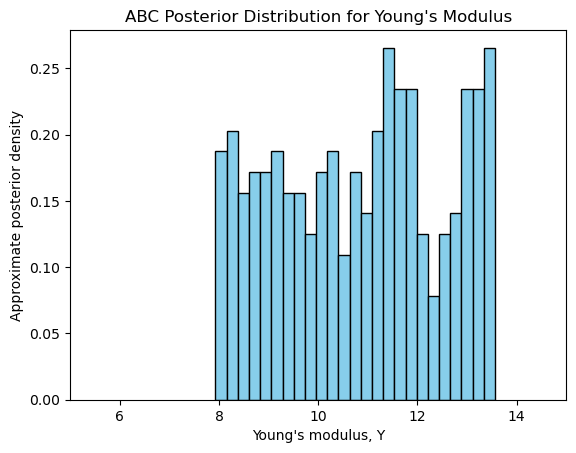

In [22]:
# Plot the histogram of accepted Young modulus values
plt.hist(accepted_Y, bins=25, density=True, color="skyblue", edgecolor="black")
plt.xlabel("Young's modulus, Y")
plt.ylabel("Approximate posterior density")
plt.title("ABC Posterior Distribution for Young's Modulus")
plt.xlim(Y_min, Y_max)
plt.show()

### Using the weighted si

In [27]:
# Number of samples to draw
N_trials = 500

# Small constant to avoid division by zero in weights
eps_w = 1e-3

# Lists to store samples and their weights
all_samples = []
all_weights = []

for i in range(N_trials):
    # Sample Y from the uniform prior
    Y_sample = np.random.uniform(Y_min, Y_max)
    
    # Solve the forward model with the sampled Young modulus.
    # Use init_U=True to reinitialize the displacement field.
    #solve_nonlinear_model(mesh=mesh, boundaries_mf=boundaries_mf, bcs=bcs, U=U, Y=Y_sample, nu=nu, P=P_obs, init_U=True)
    solve_linear_model(mesh=mesh, boundaries_mf=boundaries_mf, bcs=bcs, U=U, Y=Y_sample, nu=nu, P=P_obs, init_U=True)

    
    # Compute the discrepancy between current simulation and observed data
    d = compute_distance(U, U_obs)
    
    # Compute weight (larger weight for smaller discrepancy)
    weight = 1.0 / (d + eps_w)
    
    # Store the sample and its weight
    all_samples.append(Y_sample)
    all_weights.append(weight)
    
    print(f"Sample {i+1}/{N_trials}: Y = {Y_sample:.3f}, distance = {d:.3f}, weight = {weight:.3f}")

# Convert lists to numpy arrays for easier manipulation
all_samples = np.array(all_samples)
all_weights = np.array(all_weights)

# Normalize weights to sum to 1 (if desired)
all_weights_norm = all_weights / np.sum(all_weights)

Solving linear variational problem.
Sample 1/500: Y = 10.576, distance = 0.001, weight = 491.217
Solving linear variational problem.
Sample 2/500: Y = 13.437, distance = 0.005, weight = 170.481
Solving linear variational problem.
Sample 3/500: Y = 11.615, distance = 0.003, weight = 274.384
Solving linear variational problem.
Sample 4/500: Y = 11.747, distance = 0.003, weight = 261.182
Solving linear variational problem.
Sample 5/500: Y = 11.234, distance = 0.002, weight = 323.638
Solving linear variational problem.Sample 6/500: Y = 9.791, distance = 0.000, weight = 711.138

Solving linear variational problem.
Sample 7/500: Y = 8.159, distance = 0.004, weight = 188.919
Solving linear variational problem.
Sample 8/500: Y = 8.275, distance = 0.004, weight = 201.378
Solving linear variational problem.Sample 9/500: Y = 5.423, distance = 0.016, weight = 58.635

Solving linear variational problem.
Sample 10/500: Y = 8.157, distance = 0.004, weight = 188.759
Solving linear variational problem.

Sample 87/500: Y = 13.495, distance = 0.005, weight = 168.748Solving linear variational problem.

Solving linear variational problem.
Sample 88/500: Y = 8.840, distance = 0.002, weight = 285.981
Solving linear variational problem.
Sample 89/500: Y = 9.965, distance = 0.000, weight = 937.509
Sample 90/500: Y = 6.569, distance = 0.010, weight = 91.449
Solving linear variational problem.
Sample 91/500: Y = 10.841, distance = 0.001, weight = 404.029
Sample 92/500: Y = 9.294, distance = 0.001, weight = 408.839
Solving linear variational problem.
Solving linear variational problem.
Sample 93/500: Y = 14.704, distance = 0.006, weight = 141.134
Solving linear variational problem.
Solving linear variational problem.
Sample 94/500: Y = 12.159, distance = 0.003, weight = 228.402
Sample 95/500: Y = 12.657, distance = 0.004, weight = 200.267
Solving linear variational problem.
Sample 96/500: Y = 10.604, distance = 0.001, weight = 479.993
Sample 97/500: Y = 5.287, distance = 0.017, weight = 55.694
S


Solving linear variational problem.
Sample 177/500: Y = 11.254, distance = 0.002, weight = 320.546
Solving linear variational problem.
Sample 178/500: Y = 7.415, distance = 0.007, weight = 131.028
Solving linear variational problem.
Sample 179/500: Y = 5.560, distance = 0.015, weight = 61.768
Solving linear variational problem.Sample 180/500: Y = 14.150, distance = 0.006, weight = 152.009
Sample 181/500: Y = 10.598, distance = 0.001, weight = 482.252

Solving linear variational problem.
Sample 182/500: Y = 10.378, distance = 0.001, weight = 590.620
Solving linear variational problem.
Solving linear variational problem.
Sample 183/500: Y = 11.732, distance = 0.003, weight = 262.622
Solving linear variational problem.
Sample 184/500: Y = 5.909, distance = 0.013, weight = 70.569
Solving linear variational problem.
Sample 185/500: Y = 9.005, distance = 0.002, weight = 322.321
Solving linear variational problem.
Sample 186/500: Y = 5.522, distance = 0.015, weight = 60.886
Solving linear va

Solving linear variational problem.
Sample 269/500: Y = 11.448, distance = 0.002, weight = 293.648
Solving linear variational problem.
Sample 270/500: Y = 11.964, distance = 0.003, weight = 242.530
Solving linear variational problem.
Sample 271/500: Y = 6.177, distance = 0.012, weight = 78.304
Solving linear variational problem.Sample 272/500: Y = 8.552, distance = 0.003, weight = 236.959
Sample 273/500: Y = 6.589, distance = 0.010, weight = 92.190

Solving linear variational problem.
Solving linear variational problem.
Sample 274/500: Y = 5.053, distance = 0.019, weight = 50.964
Solving linear variational problem.
Sample 275/500: Y = 9.957, distance = 0.000, weight = 923.485
Solving linear variational problem.
Sample 276/500: Y = 5.404, distance = 0.016, weight = 58.209
Solving linear variational problem.
Sample 277/500: Y = 11.778, distance = 0.003, weight = 258.323
Solving linear variational problem.
Sample 278/500: Y = 9.807, distance = 0.000, weight = 727.645
Solving linear variat

Sample 360/500: Y = 14.369, distance = 0.006, weight = 147.417Solving linear variational problem.

Solving linear variational problem.
Sample 361/500: Y = 9.796, distance = 0.000, weight = 715.826
Solving linear variational problem.
Sample 362/500: Y = 5.081, distance = 0.018, weight = 51.504
Solving linear variational problem.
Sample 363/500: Y = 10.558, distance = 0.001, weight = 498.694
Sample 364/500: Y = 11.498, distance = 0.002, weight = 287.476
Solving linear variational problem.
Solving linear variational problem.
Sample 365/500: Y = 14.406, distance = 0.006, weight = 146.683
Solving linear variational problem.
Sample 366/500: Y = 6.976, distance = 0.008, weight = 108.152
Solving linear variational problem.
Sample 367/500: Y = 13.193, distance = 0.005, weight = 178.458
Sample 368/500: Y = 13.079, distance = 0.004, weight = 182.556Solving linear variational problem.

Solving linear variational problem.Sample 369/500: Y = 7.337, distance = 0.007, weight = 126.506

Sample 370/500:

Solving linear variational problem.
Solving linear variational problem.
Sample 447/500: Y = 9.601, distance = 0.001, weight = 558.307
Solving linear variational problem.
Sample 448/500: Y = 14.421, distance = 0.006, weight = 146.372
Solving linear variational problem.
Sample 449/500: Y = 7.276, distance = 0.007, weight = 123.125
Sample 450/500: Y = 8.936, distance = 0.002, weight = 306.393
Solving linear variational problem.
Sample 451/500: Y = 13.226, distance = 0.005, weight = 177.323
Solving linear variational problem.
Solving linear variational problem.
Sample 452/500: Y = 13.784, distance = 0.005, weight = 160.714
Solving linear variational problem.
Sample 453/500: Y = 5.041, distance = 0.019, weight = 50.728
Solving linear variational problem.
Sample 454/500: Y = 11.336, distance = 0.002, weight = 308.513
Solving linear variational problem.
Sample 455/500: Y = 10.572, distance = 0.001, weight = 492.969
Solving linear variational problem.Sample 456/500: Y = 11.012, distance = 0.00

(array([0.02207877, 0.03276597, 0.02857246, 0.03867891, 0.05024287,
        0.05141092, 0.09669108, 0.10054323, 0.0938718 , 0.28286454,
        0.28311386, 0.20922199, 0.1420942 , 0.12313243, 0.09633208,
        0.07272188, 0.08605069, 0.06330359, 0.08295493, 0.04335381]),
 array([ 5. ,  5.5,  6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. ,
        10.5, 11. , 11.5, 12. , 12.5, 13. , 13.5, 14. , 14.5, 15. ]),
 <BarContainer object of 20 artists>)

Text(0.5, 0, "Young's modulus, Y")

Text(0, 0.5, 'Approximate posterior density')

Text(0.5, 1.0, 'ABC Posterior Distribution Weighted by Inverse Discrepancy')

(5.0, 15.0)

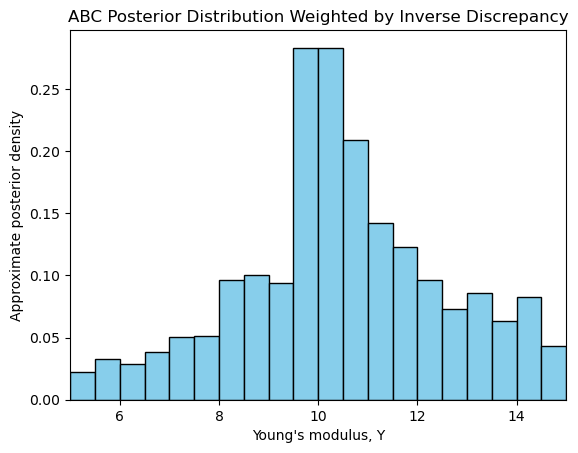

In [28]:
# Plot a weighted histogram of the samples
plt.hist(all_samples, bins=20, density=True, weights=all_weights_norm,
         range=(Y_min, Y_max), color="skyblue", edgecolor="black")
plt.xlabel("Young's modulus, Y")
plt.ylabel("Approximate posterior density")
plt.title("ABC Posterior Distribution Weighted by Inverse Discrepancy")
plt.xlim(Y_min, Y_max)  # Force x-axis to always span from Y_min to Y_max
plt.show()